## Collect images for experiment

Options:
- RGB/
- RGB_distance/

Initialization: True | False

Checkpoint:
 - 'facebook/detr-resnet-50'
 - 'facebook/detr-resnet-101'

 Freeze:
  - 'None'
  - 'Backbone'
  - 'Model'

Types of images:
 - 'All'
 - 'Good'
 - 'Bad'

Optimizers:
 - 'Adam'
 - 'AdamW'
 - 'SGD'
 - 'SGDWM'

 Learning Rate:
 - 1e-2
 - 1e-3
 - 1e-4
 - 1e-5

 Weight Decay:
  - 1e-4
  - 1e-2
  - 1e-1
  - 1e+1

In [16]:
FOLDER = 'Radiate_Image_Dataset/All_fog_images/'
TYPE_OF_IMAGES = "All" 
EXPERIMENT = "RGB/"
MAX_EPOCHS = 20
INITIALIZATION = True
CHECKPOINT = 'facebook/detr-resnet-50'
FREEZE = 'None'
BATCH_SIZE = 2
OPTIMIZER = 'AdamW'
LEARNING_RATE = 1e-4
LEARNING_RATE_BACKBONE = LEARNING_RATE * 0.1
WEIGHT_DECAY = 1e-4

## Object Detection Model

In [2]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

# Instantiate DETR with pre-trained weights for entire model
image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
#model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
#model.to(DEVICE)
#print("model loaded")

c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]


In [3]:
DEVICE

device(type='cuda', index=0)

In [4]:
import os
import torchvision
import json

folder_name = FOLDER+"fused_images/"+EXPERIMENT

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(folder_name, "train")
VAL_DIRECTORY = os.path.join(folder_name, "valid")
TEST_DIRECTORY = os.path.join(folder_name, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor
        self.annotation_file_path = annotation_file_path

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)      
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        print(annotations)
        with open(self.annotation_file_path, "r") as f:
            data = json.load(f)
        for img in data['images']:
            if img['id']==0:
                img_name = img['file_name']
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target , annotations


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY, 
    image_processor=image_processor, 
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 20
Number of validation examples: 6
Number of test examples: 2


Image #15


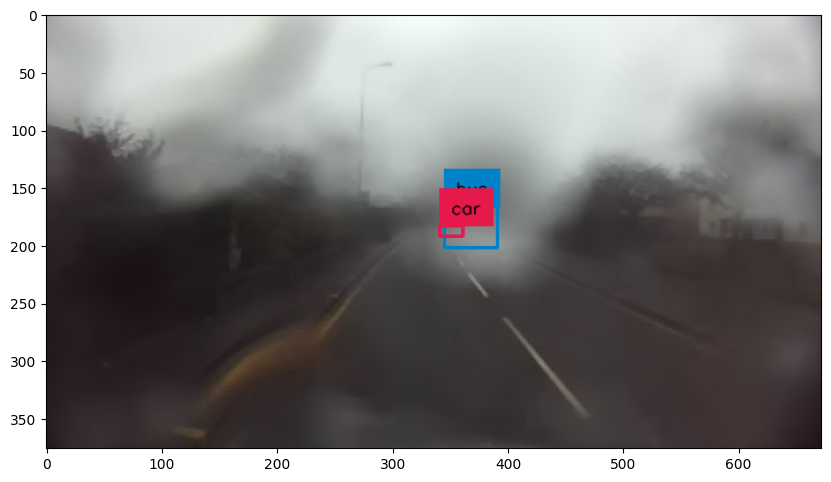

In [5]:
import random
import cv2
import numpy as np
import supervision as sv

random.seed(50)

# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)


# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]

while annotations==[]:
    image_id = random.choice(image_ids)
    image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
    annotations = TRAIN_DATASET.coco.imgToAnns[image_id]


print('Image #{}'.format(image_id))
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
detections.class_id = detections.class_id.astype(int)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = []
for _,_,class_id,_ in detections:
    labels.append(id2label[int(class_id)])

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image)

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection, DetrConfig
import torch
from torch import nn

from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=BATCH_SIZE)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=BATCH_SIZE)


class Detr(pl.LightningModule):

    def __init__(self,model, lr, lr_backbone, weight_decay, optimizer):
        super().__init__()
        
        self.model = model

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay
        self.optimizer = optimizer

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        if self.optimizer == "AdamW":
            return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer == "SGD":
            return torch.optim.SGD(param_dicts,lr=self.lr,weight_decay=self.weight_decay)
        elif self.optimizer == "Adam":
            return torch.optim.Adam(param_dicts,lr=self.lr,weight_decay=self.weight_decay)
        elif self.optimizer == "SGDWM":
            return torch.optim.SGD(param_dicts,lr=self.lr,weight_decay=self.weight_decay,momentum=0.9)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
if INITIALIZATION == True:
    model = DetrForObjectDetection.from_pretrained(
                pretrained_model_name_or_path=CHECKPOINT, 
                num_labels=len(id2label),
                ignore_mismatched_sizes=True)
else:
    config = DetrConfig()
    model = DetrForObjectDetection(config)
    model.class_labels_classifier = nn.Linear(in_features=256, out_features=9, bias=True) 

if EXPERIMENT == "RGB_distance/":
    model.model.backbone.conv_encoder.model.conv1 =  torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

model = Detr(model,lr=LEARNING_RATE, lr_backbone=LEARNING_RATE_BACKBONE, weight_decay=WEIGHT_DECAY, optimizer=OPTIMIZER)

if FREEZE == 'Backbone':
    for param in model.model.model.backbone.parameters():
        param.requires_grad=False

if FREEZE == "Model":
    for param in model.model.model.parameters():
        param.requires_grad=False
        
model.to(DEVICE)
# batch = next(iter(TRAIN_DATALOADER))
# outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:2441: UserWarning: for bn1.bias: copying from a non-meta par

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [8]:
from pytorch_lightning import Trainer

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=1,log_every_n_steps=10)

trainer.fit(model,train_dataloaders=TRAIN_DATALOADER, val_dataloaders=VAL_DATALOADER)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


{'image_id': 22, 'annotations': [{'id': 46, 'image_id': 22, 'category_id': '3', 'bbox': [349, 173, 24, 19], 'area': 456, 'segmentation': [], 'iscrowd': 0}, {'id': 47, 'image_id': 22, 'category_id': '0', 'bbox': [332, 183, 15, 9], 'area': 135, 'segmentation': [], 'iscrowd': 0}]}
{'image_id': 23, 'annotations': [{'id': 48, 'image_id': 23, 'category_id': '3', 'bbox': [349, 173, 25, 19], 'area': 475, 'segmentation': [], 'iscrowd': 0}, {'id': 49, 'image_id': 23, 'category_id': '0', 'bbox': [334, 183, 17, 10], 'area': 170, 'segmentation': [], 'iscrowd': 0}]}
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s]{'image_id': 24, 'annotations': [{'id': 50, 'image_id': 24, 'category_id': '3', 'bbox': [346, 168, 43, 32], 'area': 1376, 'segmentation': [], 'iscrowd': 0}, {'id': 51, 'image_id': 24, 'category_id': '0', 'bbox': [415, 197, 257, 179], 'area': 46003, 'segmentation': [], 'iscrowd': 0}, {'id': 52, 'image_id': 24, 'category_id': '0', 'bbox': [344, 183, 19, 8], 'area': 

c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\grt2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:527: Found 399 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]{'image_id': 2, 'annotations': [{'id': 5, 'image_id': 2, 'category_id': '3', 'bbox': [348, 170, 33, 27], 'area': 891, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 2, 'category_id': '0', 'bbox': [340, 185, 51, 32], 'area': 1632, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 2, 'category_id': '0', 'bbox': [347, 182, 16, 8], 'area': 128, 'segmentation': [], 'iscrowd': 0}]}
{'image_id': 18, 'annotations': [{'id': 37, 'image_id': 18, 'category_id': '3', 'bbox': [345, 168, 38, 31], 'area': 1178, 'segmentation': [], 'iscrowd': 0}, {'id': 38, 'image_id': 18, 'category_id': '0', 'bbox': [359, 190, 158, 91], 'area': 14378, 'segmentation': [], 'iscrowd': 0}, {'id': 39, 'image_id': 18, 'category_id': '0', 'bbox': [343, 182, 19, 9], 'area': 171, 'segmentation': [], 'iscrowd': 0}]}
Epoch 0:  10%|█         | 1/10 [00:00<00:04,  2.22it/s, v_num=1]{'image_id': 7, 'annotations': [{'id': 14, 'image_id': 7, 'category_id': '3', 'bbox': [

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s, v_num=1]


Image #21
ground truth


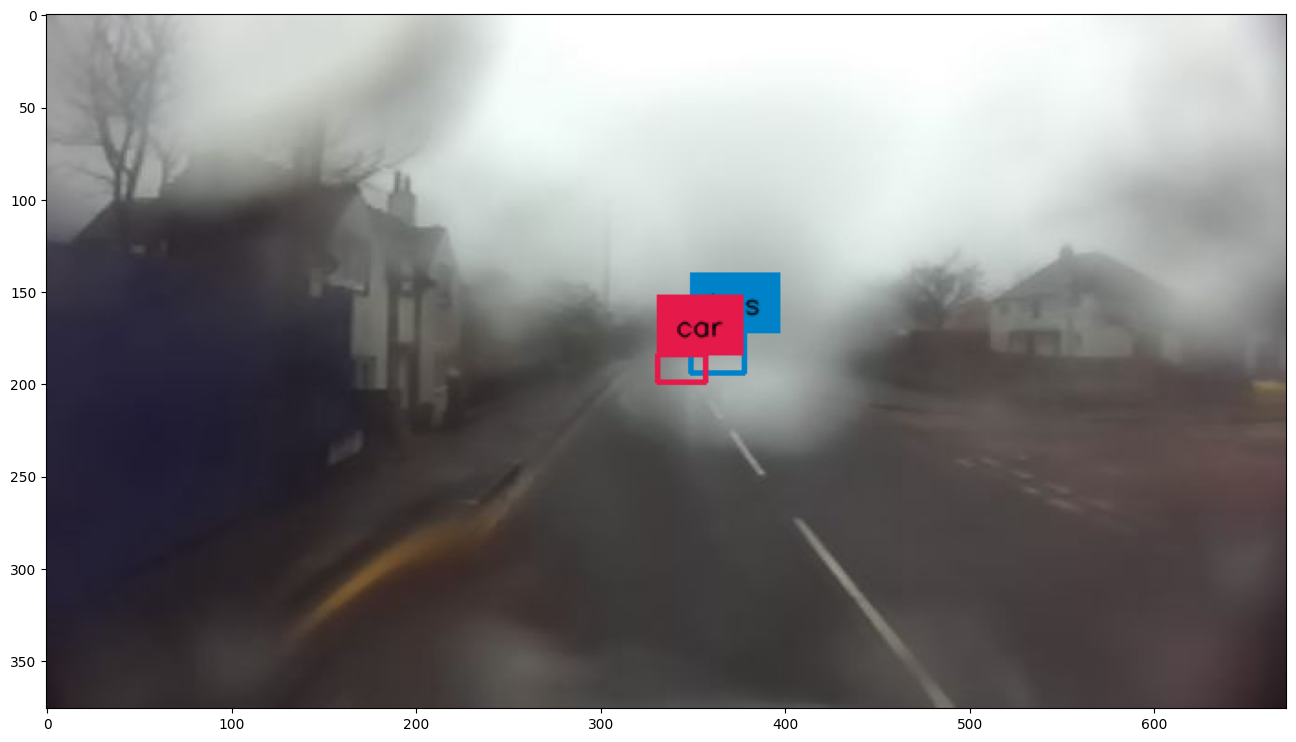

In [9]:
import random
import cv2
import numpy as np

random.seed(40)

# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)


# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
while annotations==[]:
    image_id = random.choice(image_ids)
    image = TEST_DATASET.coco.loadImgs(image_id)[0]
    annotations = TEST_DATASET.coco.imgToAnns[image_id]

print('Image #{}'.format(image_id))
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
detections.class_id = detections.class_id.astype(int)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))


# Save model and test images

In [67]:
model_name = ""
if TYPE_OF_IMAGES == "All":
    model_name += "AI"
elif TYPE_OF_IMAGES == "Good":
    model_name += "GI"
elif TYPE_OF_IMAGES == "Bad":
    model_name += "BI"

model_name+= "_E" + str(MAX_EPOCHS) + "_"

if FREEZE == "None":
    model_name += "FN"
elif FREEZE == "Backbone":
    model_name += "FB"
elif FREEZE == "Model":
    model_name += "FM"

if INITIALIZATION == True:
    model_name += "_IP_"
elif INITIALIZATION == False:
    model_name += "_IX_"

if CHECKPOINT == 'facebook/detr-resnet-50':
    model_name += "C50_"
elif CHECKPOINT == 'facebook/detr-resnet-101':
    model_name += "C101_"

model_name += "B"+str(BATCH_SIZE)

if OPTIMIZER == "AdamW":
    model_name += "_OAW"
elif OPTIMIZER == "Adam":
    model_name += "_OA"
elif OPTIMIZER == "SGD":
    model_name += "_OSGD"
elif OPTIMIZER == "SGDWM":
    model_name += "_OSGDWM"

if LEARNING_RATE == 1e-2:
    model_name += "++"
elif LEARNING_RATE == 1e-3:
    model_name += "+"
elif LEARNING_RATE == 1e-5:
    model_name += "-"

if WEIGHT_DECAY == 1e-4:
    model_name+= "WD1e-4"
elif WEIGHT_DECAY == 1e-2:
    model_name+= "WD1e-2"
elif WEIGHT_DECAY == 1e-1:
    model_name+= "WD1e-1"
elif WEIGHT_DECAY == 1e+1:
    model_name+= "WD1e+1"



In [68]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm

model_folder = FOLDER+"models/"+str(MAX_EPOCHS)


Path("models/"+model_name).mkdir(exist_ok=True,parents=True)
Path("models/"+model_name+"/saved_images").mkdir(exist_ok=True,parents=True)


model.model.save_pretrained("models/"+model_name)

In [70]:
model.to(DEVICE)

counter=0

for image_id in tqdm(image_ids):
    image = TEST_DATASET.coco.loadImgs(image_id)[0]
    annotations = TEST_DATASET.coco.imgToAnns[image_id]
    image_path = os.path.join(TEST_DATASET.root, image['file_name'])
    image = cv2.imread(image_path)
    if annotations == []:
        cv2.imwrite("models/"+model_name+"/saved_images/Image_"+str(image_id)+".png",image)
        continue


    # inference
    with torch.no_grad():

        # load image and predict
        inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
        outputs = model(**inputs)

        # post-process
        target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
        results = image_processor.post_process_object_detection(
            outputs=outputs, 
            threshold=0.6, 
            target_sizes=target_sizes
        )[0]

    if len(results['boxes']) == 0:
        cv2.imwrite("models/"+model_name+"/saved_images/Image_"+str(image_id)+".png",image)
        continue

    # annotate
    detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.1)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    # print(detections)
    # %matplotlib inline  
    # sv.show_frame_in_notebook(frame, (16, 16))
    cv2.imwrite("models/"+model_name+"/saved_images/Image_"+str(image_id)+".png",frame)
    counter+=1
    if counter==1000:
        break

100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


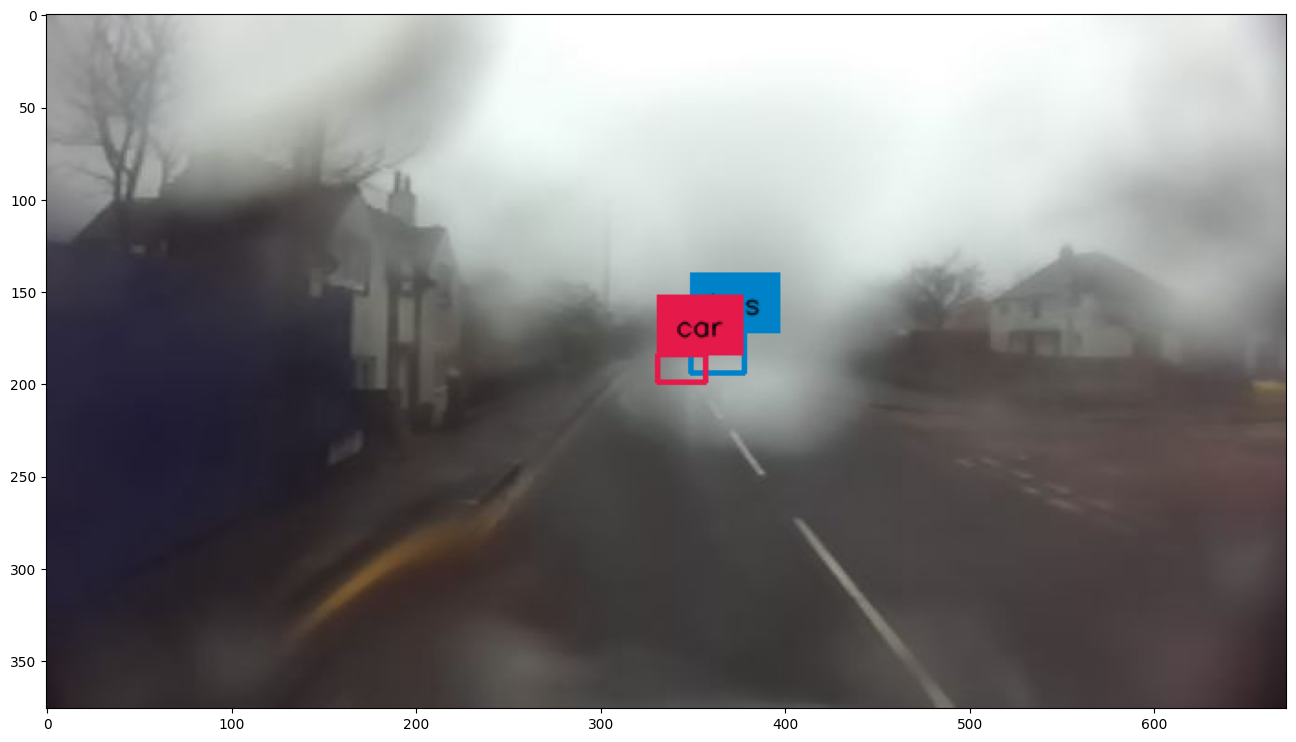

In [71]:
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

# Copy paste to graphs and change name of version

In [ ]:
Path("graphs").mkdir(parents=True,exist_ok=True)
try:
    destination = os.listdir("graphs/"+model_name)
except:
    os.mkdir("graphs/"+model_name)
    destination = os.listdir("graphs/"+model_name)

target_folder = os.listdir("lightning_logs/")[-1]
target = os.listdir("lightning_logs/"+target_folder)
for file in target:
    try:
        shutil.copy("lightning_logs/"+target_folder+"/"+file,"graphs/"+model_name)
        os.remove("lightning_logs/"+target_folder+"/"+file)
    except:
        sub_file = os.listdir("lightning_logs/"+target_folder+"/"+file)
        Path("graphs/"+model_name+"/"+file).mkdir(parents=True, exist_ok=True)
        shutil.copy("lightning_logs/"+target_folder+"/"+file+"/"+sub_file[0],"graphs/"+model_name+"/"+file)
        os.remove("lightning_logs/"+target_folder+"/"+file+"/"+sub_file[0])

os.rmdir("lightning_logs/"+target_folder+"/checkpoints/")
os.rmdir("lightning_logs/"+target_folder)